In [1]:
import random
import json

import numpy as np

import pandas as pd

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator

import math

In [2]:
class WordleCritic:
    def __init__(self, word):
        self.word = word
        
    def judge(self, suggestion):
        result = ["gray" for i in range(len(self.word))]
        
        for index, letter in enumerate(suggestion):
            if letter == self.word[index]:
                result[index] = "green"
            elif letter in self.word:
                result[index] = "yellow"
                
        return result

In [3]:
class WordlePlayer:
    def __init__(self, words_file, model):
        self.words_pd = pd.read_csv(words_file + ".csv")
        
        with open(words_file + ".json", "r") as f:
            self.words_list = json.load(f) 
        
        self.model = model

        self.model.fit(self.words_pd, estimator=MaximumLikelihoodEstimator)
        self.infer = VariableElimination(self.model)
        
    def get_suggestion_word(self, suggestion, evidence):
        word = ["", "", "", "", ""]

        if "first" in evidence:
            word[0] = evidence["first"]
        else: 
            word[0] = suggestion["first"]

        if "second" in evidence:
            word[1] = evidence["second"]
        else:
            word[1] = suggestion["second"]

        if "third" in evidence:
            word[2] = evidence["third"]
        else:
            word[2] = suggestion["third"]

        if "forth" in evidence:
            word[3] = evidence["forth"]
        else:
            word[3] = suggestion["forth"]

        if "fifth" in evidence:
            word[4] = evidence["fifth"]
        else:
            word[4] = suggestion["fifth"]

        return word

    def word_is_valid(self, word, must_contain=[], must_not_contain=[], must_not_contain_at={}):
        if "".join(str(char) for char in word) in self.words_list:

            for letter in must_contain:
                if not letter in word:
                    return False

            for letter in must_not_contain:
                if letter in word:
                    return False

            if "first" in must_not_contain_at and word[0] in must_not_contain_at["first"]:
                return False
            
            if "second" in must_not_contain_at and word[1] in must_not_contain_at["second"]:
                return False

            if "third" in must_not_contain_at and word[2] in must_not_contain_at["third"]:
                return False

            if "forth" in must_not_contain_at and word[3] in must_not_contain_at["forth"]:
                return False

            if "fifth" in must_not_contain_at and word[4] in must_not_contain_at["fifth"]:
                return False

            return True
        else:
            return False

    def get_suggestion(self, variables, evidence, must_contain=[], must_not_contain=[], must_not_contain_at=[]):
        q = self.infer.query(variables, evidence=evidence, show_progress=False)

        count_predictions = len(q.values.flatten()[q.values.flatten() != 0])
        max_value_indices = (-q.values.flatten()).argsort()[:count_predictions]

        result = []

        for max_value_index in max_value_indices:
            indices = np.unravel_index(max_value_index, q.values.shape)

            suggestion = {}

            for index, variable in enumerate(q.variables):
                suggestion[variable] = self.model.get_cpds(variable).state_names[variable][indices[index]]

            word = self.get_suggestion_word(suggestion, evidence)

            if self.word_is_valid(word, must_contain, must_not_contain, must_not_contain_at):
                #result.append(word)
                return word

        return result
    
    def get_first_suggestion(self):
        first = self.infer.map_query(["first"], show_progress=False)["first"]
        second = self.infer.map_query(["second"], evidence={"first": first}, show_progress=False)["second"]
        third = self.infer.map_query(["third"], evidence={"first": first, "second": second}, show_progress=False)["third"]
        forth = self.infer.map_query(["forth"], evidence={"first": first, "second": second, "third": third}, show_progress=False)["forth"]
        fifth = self.infer.map_query(["fifth"], evidence={"first": first, "second": second, "third": third, "forth": forth}, show_progress=False)["fifth"]

        if self.word_is_valid("".join([first,second,third,forth,fifth])):
            return "".join[first,second,third,forth,fifth]
        elif len(self.words_pd[
                (self.words_pd["first"] == first) & 
                (self.words_pd["second"] == second) & 
                (self.words_pd["third"] == third) & 
                (self.words_pd["forth"] == forth)]) > 0:
            return self.words_pd[
                (self.words_pd["first"] == first) & 
                (self.words_pd["second"] == second) & 
                (self.words_pd["third"] == third) & 
                (self.words_pd["forth"] == forth)].values[0]
        else:
            return self.words_pd[
                (self.words_pd["first"] == first) & 
                (self.words_pd["second"] == second) & 
                (self.words_pd["third"] == third)].values[0]
        

In [5]:
with open("words.json", "r") as f:
    words = json.load(f)

word = random.choice(words)

critic = WordleCritic(word)

print(critic.word)

LUFTE


In [5]:
model = BayesianNetwork([
    ("first", "second"), 
    ("third", "second"), 
    ("third", "forth"), 
    ("fifth", "forth")
])

player = WordlePlayer("wordle-at-words", model)

suggestion = player.get_first_suggestion()

new_input = {
    "variables":set([]), 
    "evidence":{}, 
    "must_contain":set([]), 
    "must_not_contain":set([]),
    "must_not_contain_at":{
        "first":set([]), 
        "second":set([]), 
        "third":set([]),
        "forth":set([]),
        "fifth":set([])
    }
}

tries = 0

while True:
    evidences = critic.judge(suggestion)
    tries += 1
    
    print(str(tries) + ": " + "".join(suggestion))
    print(evidences)
    print()
    
    if evidences[0] == "green" and evidences[1] == "green" and evidences[2] == "green" and evidences[3] == "green" and evidences[4] == "green":
        break
    
    if evidences[0] == "gray":
        new_input["variables"].add("first")
        new_input["must_not_contain"].add(suggestion[0])
    elif evidences[0] == "yellow":
        new_input["variables"].add("first")
        new_input["must_contain"].add(suggestion[0])
        new_input["must_not_contain_at"]["first"].add(suggestion[0])
    elif evidences[0] == "green":
        new_input["variables"].discard("first")
        new_input["evidence"]["first"] = suggestion[0]

    if evidences[1] == "gray":
        new_input["variables"].add("second")
        new_input["must_not_contain"].add(suggestion[1])
    elif evidences[1] == "yellow":
        new_input["variables"].add("second")
        new_input["must_contain"].add(suggestion[1])
        new_input["must_not_contain_at"]["second"].add(suggestion[1])
    elif evidences[1] == "green":
        new_input["variables"].discard("second")
        new_input["evidence"]["second"] = suggestion[1]

    if evidences[2] == "gray":
        new_input["variables"].add("third")
        new_input["must_not_contain"].add(suggestion[2])
    elif evidences[2] == "yellow":
        new_input["variables"].add("third")
        new_input["must_contain"].add(suggestion[2])
        new_input["must_not_contain_at"]["third"].add(suggestion[2])
    elif evidences[2] == "green":
        new_input["variables"].discard("third")
        new_input["evidence"]["third"] = suggestion[2]

    if evidences[3] == "gray":
        new_input["variables"].add("forth")
        new_input["must_not_contain"].add(suggestion[3])
    elif evidences[3] == "yellow":
        new_input["variables"].add("forth")
        new_input["must_contain"].add(suggestion[3])
        new_input["must_not_contain_at"]["forth"].add(suggestion[3])
    elif evidences[3] == "green":
        new_input["variables"].discard("forth")
        new_input["evidence"]["forth"] = suggestion[3]

    if evidences[4] == "gray":
        new_input["variables"].add("fifth")
        new_input["must_not_contain"].add(suggestion[4])
    elif evidences[4] == "yellow":
        new_input["variables"].add("fifth")
        new_input["must_contain"].add(suggestion[4])
        new_input["must_not_contain_at"]["fifth"].add(suggestion[4])
    elif evidences[4] == "green":
        new_input["variables"].discard("fifth")
        new_input["evidence"]["fifth"] = suggestion[4]

    suggestion = player.get_suggestion(
        new_input["variables"], 
        new_input["evidence"],
        new_input["must_contain"],
        new_input["must_not_contain"],
        new_input["must_not_contain_at"]
    )
    
print("The word you are looking for is " + "".join(suggestion) + "!")
print("Found it in " + str(tries) + " tries!")

1: SABOR
['gray', 'gray', 'gray', 'gray', 'yellow']

2: REINE
['yellow', 'yellow', 'yellow', 'gray', 'green']

3: MIERE
['gray', 'green', 'green', 'green', 'green']

4: PIERE
['gray', 'green', 'green', 'green', 'green']

5: VIERE
['gray', 'green', 'green', 'green', 'green']

6: ZIERE
['gray', 'green', 'green', 'green', 'green']

7: TIERE
['green', 'green', 'green', 'green', 'green']

The word you are looking for is TIERE!
Found it in 7 tries!


In [10]:
tries_all_words = []

for word in words: 
    critic = WordleCritic(word)
    
    model = BayesianNetwork([
        ("first", "second"), 
        ("second", "third"), 
        ("forth", "third"), 
        ("fifth", "forth")
    ])

    player = WordlePlayer("words", model)

    suggestion = player.get_first_suggestion()

    new_input = {
        "variables":set([]), 
        "evidence":{}, 
        "must_contain":set([]), 
        "must_not_contain":set([]),
        "must_not_contain_at":{
            "first":set([]), 
            "second":set([]), 
            "third":set([]),
            "forth":set([]),
            "fifth":set([])
        }
    }

    tries = 0

    while True:
        evidences = critic.judge(suggestion)
        tries += 1

        if evidences[0] == "green" and evidences[1] == "green" and evidences[2] == "green" and evidences[3] == "green" and evidences[4] == "green":
            break

        if evidences[0] == "gray":
            new_input["variables"].add("first")
            new_input["must_not_contain"].add(suggestion[0])
        elif evidences[0] == "yellow":
            new_input["variables"].add("first")
            new_input["must_contain"].add(suggestion[0])
            new_input["must_not_contain_at"]["first"].add(suggestion[0])
        elif evidences[0] == "green":
            new_input["variables"].discard("first")
            new_input["evidence"]["first"] = suggestion[0]

        if evidences[1] == "gray":
            new_input["variables"].add("second")
            new_input["must_not_contain"].add(suggestion[1])
        elif evidences[1] == "yellow":
            new_input["variables"].add("second")
            new_input["must_contain"].add(suggestion[1])
            new_input["must_not_contain_at"]["second"].add(suggestion[1])
        elif evidences[1] == "green":
            new_input["variables"].discard("second")
            new_input["evidence"]["second"] = suggestion[1]

        if evidences[2] == "gray":
            new_input["variables"].add("third")
            new_input["must_not_contain"].add(suggestion[2])
        elif evidences[2] == "yellow":
            new_input["variables"].add("third")
            new_input["must_contain"].add(suggestion[2])
            new_input["must_not_contain_at"]["third"].add(suggestion[2])
        elif evidences[2] == "green":
            new_input["variables"].discard("third")
            new_input["evidence"]["third"] = suggestion[2]

        if evidences[3] == "gray":
            new_input["variables"].add("forth")
            new_input["must_not_contain"].add(suggestion[3])
        elif evidences[3] == "yellow":
            new_input["variables"].add("forth")
            new_input["must_contain"].add(suggestion[3])
            new_input["must_not_contain_at"]["forth"].add(suggestion[3])
        elif evidences[3] == "green":
            new_input["variables"].discard("forth")
            new_input["evidence"]["forth"] = suggestion[3]

        if evidences[4] == "gray":
            new_input["variables"].add("fifth")
            new_input["must_not_contain"].add(suggestion[4])
        elif evidences[4] == "yellow":
            new_input["variables"].add("fifth")
            new_input["must_contain"].add(suggestion[4])
            new_input["must_not_contain_at"]["fifth"].add(suggestion[4])
        elif evidences[4] == "green":
            new_input["variables"].discard("fifth")
            new_input["evidence"]["fifth"] = suggestion[4]

        suggestion = player.get_suggestion(
            new_input["variables"], 
            new_input["evidence"],
            new_input["must_contain"],
            new_input["must_not_contain"],
            new_input["must_not_contain_at"]
        )

    print("The word you are looking for is " + "".join(suggestion) + "! Found it in " + str(tries) + " tries. ")
    tries_all_words.append(tries)

The word you are looking for is ERWEB! Found it in 4 tries. 
The word you are looking for is HOLKS! Found it in 4 tries. 
The word you are looking for is WUSLE! Found it in 6 tries. 
The word you are looking for is PAGEN! Found it in 8 tries. 
The word you are looking for is KOMME! Found it in 5 tries. 
The word you are looking for is BASTA! Found it in 4 tries. 
The word you are looking for is LAHRS! Found it in 4 tries. 
The word you are looking for is ZAREN! Found it in 7 tries. 
The word you are looking for is WRIGG! Found it in 6 tries. 
The word you are looking for is STIFT! Found it in 3 tries. 
The word you are looking for is LESET! Found it in 3 tries. 
The word you are looking for is ABASS! Found it in 3 tries. 
The word you are looking for is DOSHA! Found it in 4 tries. 
The word you are looking for is MUHTS! Found it in 6 tries. 
The word you are looking for is NEPPE! Found it in 5 tries. 
The word you are looking for is KUJON! Found it in 5 tries. 
The word you are looking

The word you are looking for is ALETS! Found it in 3 tries. 
The word you are looking for is RIADS! Found it in 4 tries. 
The word you are looking for is LISTS! Found it in 3 tries. 
The word you are looking for is FLATS! Found it in 4 tries. 
The word you are looking for is PULPA! Found it in 5 tries. 
The word you are looking for is RIGGT! Found it in 5 tries. 
The word you are looking for is MEMEN! Found it in 7 tries. 
The word you are looking for is DAUEN! Found it in 8 tries. 
The word you are looking for is ZERGT! Found it in 5 tries. 
The word you are looking for is DUSLE! Found it in 4 tries. 
The word you are looking for is TOBAK! Found it in 5 tries. 
The word you are looking for is ERLOG! Found it in 4 tries. 
The word you are looking for is DIREX! Found it in 4 tries. 
The word you are looking for is HINDU! Found it in 5 tries. 
The word you are looking for is ZUTAT! Found it in 5 tries. 
The word you are looking for is SUCHT! Found it in 3 tries. 
The word you are looking

The word you are looking for is IMMOS! Found it in 5 tries. 
The word you are looking for is WALLT! Found it in 6 tries. 
The word you are looking for is FROEN! Found it in 5 tries. 
The word you are looking for is MONOM! Found it in 5 tries. 
The word you are looking for is GREMM! Found it in 4 tries. 
The word you are looking for is SINAH! Found it in 5 tries. 
The word you are looking for is BUHLT! Found it in 4 tries. 
The word you are looking for is HELFE! Found it in 5 tries. 
The word you are looking for is GIPSE! Found it in 6 tries. 
The word you are looking for is MUNGO! Found it in 4 tries. 
The word you are looking for is JELEN! Found it in 7 tries. 
The word you are looking for is FELIX! Found it in 6 tries. 
The word you are looking for is LAUES! Found it in 5 tries. 
The word you are looking for is HOLDE! Found it in 5 tries. 
The word you are looking for is OWENS! Found it in 6 tries. 
The word you are looking for is RUEGE! Found it in 4 tries. 
The word you are looking

The word you are looking for is BETAT! Found it in 4 tries. 
The word you are looking for is DROHE! Found it in 6 tries. 
The word you are looking for is HYPET! Found it in 5 tries. 
The word you are looking for is CROON! Found it in 4 tries. 
The word you are looking for is MAULE! Found it in 4 tries. 
The word you are looking for is SONDE! Found it in 5 tries. 
The word you are looking for is KULTE! Found it in 6 tries. 
The word you are looking for is NIMMT! Found it in 5 tries. 
The word you are looking for is LIEKS! Found it in 6 tries. 
The word you are looking for is WIRRE! Found it in 5 tries. 
The word you are looking for is BRAVI! Found it in 3 tries. 
The word you are looking for is LOTES! Found it in 6 tries. 
The word you are looking for is KOALA! Found it in 5 tries. 
The word you are looking for is BERNT! Found it in 5 tries. 
The word you are looking for is GLANZ! Found it in 5 tries. 
The word you are looking for is VOPOS! Found it in 5 tries. 
The word you are looking

The word you are looking for is DAKER! Found it in 5 tries. 
The word you are looking for is TROEL! Found it in 5 tries. 
The word you are looking for is BOSON! Found it in 3 tries. 
The word you are looking for is REEPS! Found it in 4 tries. 
The word you are looking for is SIRUP! Found it in 4 tries. 
The word you are looking for is DAWAI! Found it in 6 tries. 
The word you are looking for is JAMME! Found it in 5 tries. 
The word you are looking for is SLIPP! Found it in 4 tries. 
The word you are looking for is HAIES! Found it in 4 tries. 
The word you are looking for is KLAUT! Found it in 5 tries. 
The word you are looking for is LEBST! Found it in 6 tries. 
The word you are looking for is MICHI! Found it in 4 tries. 
The word you are looking for is LANGE! Found it in 5 tries. 
The word you are looking for is CALLS! Found it in 4 tries. 
The word you are looking for is STROM! Found it in 4 tries. 
The word you are looking for is SILAU! Found it in 4 tries. 
The word you are looking

The word you are looking for is WIPPT! Found it in 5 tries. 
The word you are looking for is HAACK! Found it in 4 tries. 
The word you are looking for is SAHNE! Found it in 4 tries. 
The word you are looking for is HABIL! Found it in 4 tries. 
The word you are looking for is WANDA! Found it in 5 tries. 
The word you are looking for is TSUBA! Found it in 4 tries. 
The word you are looking for is PFAFF! Found it in 6 tries. 
The word you are looking for is BUACH! Found it in 5 tries. 
The word you are looking for is SPORN! Found it in 3 tries. 
The word you are looking for is TEWET! Found it in 6 tries. 
The word you are looking for is WIRKE! Found it in 6 tries. 
The word you are looking for is DOJOS! Found it in 6 tries. 
The word you are looking for is VAGEN! Found it in 12 tries. 
The word you are looking for is ALLES! Found it in 4 tries. 
The word you are looking for is HAEMT! Found it in 5 tries. 
The word you are looking for is KAHBA! Found it in 5 tries. 
The word you are lookin

The word you are looking for is HALTS! Found it in 4 tries. 
The word you are looking for is TOPPT! Found it in 6 tries. 
The word you are looking for is TRIFF! Found it in 4 tries. 
The word you are looking for is SCHAH! Found it in 5 tries. 
The word you are looking for is NASSE! Found it in 8 tries. 
The word you are looking for is FETAS! Found it in 5 tries. 
The word you are looking for is NERIS! Found it in 3 tries. 
The word you are looking for is KRAME! Found it in 6 tries. 
The word you are looking for is HAUCH! Found it in 3 tries. 
The word you are looking for is BUERO! Found it in 4 tries. 
The word you are looking for is GIKSE! Found it in 6 tries. 
The word you are looking for is KAPPT! Found it in 5 tries. 
The word you are looking for is LASUR! Found it in 6 tries. 
The word you are looking for is BIKST! Found it in 4 tries. 
The word you are looking for is ANLAG! Found it in 5 tries. 
The word you are looking for is HUSCH! Found it in 4 tries. 
The word you are looking

The word you are looking for is NONAN! Found it in 4 tries. 
The word you are looking for is REGTE! Found it in 5 tries. 
The word you are looking for is VACKE! Found it in 12 tries. 
The word you are looking for is ERNST! Found it in 5 tries. 
The word you are looking for is EHRET! Found it in 5 tries. 
The word you are looking for is LOBET! Found it in 4 tries. 
The word you are looking for is DIODE! Found it in 6 tries. 
The word you are looking for is RUMEN! Found it in 5 tries. 
The word you are looking for is JAULT! Found it in 7 tries. 
The word you are looking for is HERZE! Found it in 7 tries. 
The word you are looking for is ROTHS! Found it in 5 tries. 
The word you are looking for is WILDE! Found it in 4 tries. 
The word you are looking for is BABYS! Found it in 6 tries. 
The word you are looking for is DOCKT! Found it in 5 tries. 
The word you are looking for is RANKT! Found it in 4 tries. 
The word you are looking for is LAUGE! Found it in 8 tries. 
The word you are lookin

The word you are looking for is UMLUD! Found it in 5 tries. 
The word you are looking for is HANGS! Found it in 4 tries. 
The word you are looking for is LOITS! Found it in 4 tries. 
The word you are looking for is EAGLE! Found it in 8 tries. 
The word you are looking for is WEBER! Found it in 4 tries. 
The word you are looking for is SAHTI! Found it in 3 tries. 
The word you are looking for is FLARE! Found it in 4 tries. 
The word you are looking for is FAXET! Found it in 7 tries. 
The word you are looking for is WEIHE! Found it in 5 tries. 
The word you are looking for is KASSA! Found it in 3 tries. 
The word you are looking for is GLEIT! Found it in 4 tries. 
The word you are looking for is DATEN! Found it in 7 tries. 
The word you are looking for is TOELT! Found it in 5 tries. 
The word you are looking for is HABER! Found it in 6 tries. 
The word you are looking for is MAEST! Found it in 4 tries. 
The word you are looking for is DARME! Found it in 5 tries. 
The word you are looking

The word you are looking for is LILLI! Found it in 2 tries. 
The word you are looking for is POHLS! Found it in 5 tries. 
The word you are looking for is HELLE! Found it in 3 tries. 
The word you are looking for is HEIDE! Found it in 4 tries. 
The word you are looking for is WURST! Found it in 7 tries. 
The word you are looking for is RIGAS! Found it in 4 tries. 
The word you are looking for is ORLOG! Found it in 4 tries. 
The word you are looking for is JASON! Found it in 4 tries. 
The word you are looking for is KOREN! Found it in 4 tries. 
The word you are looking for is SURFE! Found it in 5 tries. 
The word you are looking for is ZOLLE! Found it in 9 tries. 
The word you are looking for is KLEIN! Found it in 5 tries. 
The word you are looking for is KLICK! Found it in 4 tries. 
The word you are looking for is CAJON! Found it in 4 tries. 
The word you are looking for is TAPES! Found it in 10 tries. 
The word you are looking for is GOOFY! Found it in 4 tries. 
The word you are lookin

The word you are looking for is ROSEN! Found it in 4 tries. 
The word you are looking for is DENEN! Found it in 5 tries. 
The word you are looking for is KURTE! Found it in 6 tries. 
The word you are looking for is HYPTE! Found it in 5 tries. 
The word you are looking for is MAJOS! Found it in 5 tries. 
The word you are looking for is METRA! Found it in 5 tries. 
The word you are looking for is HALSE! Found it in 4 tries. 
The word you are looking for is ZIPPT! Found it in 6 tries. 
The word you are looking for is MEHRE! Found it in 6 tries. 
The word you are looking for is SUDRE! Found it in 5 tries. 
The word you are looking for is NOXEN! Found it in 7 tries. 
The word you are looking for is FADEN! Found it in 8 tries. 
The word you are looking for is TAKTE! Found it in 4 tries. 
The word you are looking for is PALET! Found it in 6 tries. 
The word you are looking for is MOHEL! Found it in 5 tries. 
The word you are looking for is PASTA! Found it in 5 tries. 
The word you are looking

The word you are looking for is ZUSAH! Found it in 4 tries. 
The word you are looking for is MOLLS! Found it in 4 tries. 
The word you are looking for is GEBOT! Found it in 4 tries. 
The word you are looking for is SPACK! Found it in 4 tries. 
The word you are looking for is KAMMS! Found it in 4 tries. 
The word you are looking for is CODEX! Found it in 4 tries. 
The word you are looking for is BISTE! Found it in 4 tries. 
The word you are looking for is SPAET! Found it in 3 tries. 
The word you are looking for is GEREU! Found it in 5 tries. 
The word you are looking for is GLATT! Found it in 4 tries. 
The word you are looking for is DAREM! Found it in 5 tries. 
The word you are looking for is PIANS! Found it in 2 tries. 
The word you are looking for is POTTE! Found it in 6 tries. 
The word you are looking for is SASSE! Found it in 2 tries. 
The word you are looking for is PASTE! Found it in 7 tries. 
The word you are looking for is GERBT! Found it in 4 tries. 
The word you are looking

The word you are looking for is GEUZT! Found it in 7 tries. 
The word you are looking for is KOKLE! Found it in 6 tries. 
The word you are looking for is AGIOS! Found it in 6 tries. 
The word you are looking for is AMORS! Found it in 5 tries. 
The word you are looking for is ERWOB! Found it in 4 tries. 
The word you are looking for is EUGEN! Found it in 6 tries. 
The word you are looking for is BREZN! Found it in 4 tries. 
The word you are looking for is MOPPT! Found it in 5 tries. 
The word you are looking for is FERNE! Found it in 6 tries. 
The word you are looking for is NACHT! Found it in 4 tries. 
The word you are looking for is FUNKT! Found it in 5 tries. 
The word you are looking for is KOBOT! Found it in 4 tries. 
The word you are looking for is LANDS! Found it in 6 tries. 
The word you are looking for is MELKE! Found it in 5 tries. 
The word you are looking for is KREDO! Found it in 4 tries. 
The word you are looking for is BOETE! Found it in 4 tries. 
The word you are looking

The word you are looking for is DUTZT! Found it in 4 tries. 
The word you are looking for is AHAUS! Found it in 5 tries. 
The word you are looking for is ALGER! Found it in 5 tries. 
The word you are looking for is PISTE! Found it in 3 tries. 
The word you are looking for is SIEGT! Found it in 4 tries. 
The word you are looking for is ALTER! Found it in 3 tries. 
The word you are looking for is HYADE! Found it in 5 tries. 
The word you are looking for is BANJA! Found it in 4 tries. 
The word you are looking for is FETTE! Found it in 4 tries. 
The word you are looking for is KIOTO! Found it in 4 tries. 
The word you are looking for is EIDAM! Found it in 4 tries. 
The word you are looking for is ALTES! Found it in 4 tries. 
The word you are looking for is RENNT! Found it in 6 tries. 
The word you are looking for is AKKUS! Found it in 6 tries. 
The word you are looking for is DAHAT! Found it in 6 tries. 
The word you are looking for is BACKT! Found it in 4 tries. 
The word you are looking

The word you are looking for is HAHNS! Found it in 4 tries. 
The word you are looking for is EINES! Found it in 4 tries. 
The word you are looking for is AZURS! Found it in 5 tries. 
The word you are looking for is XETRA! Found it in 5 tries. 
The word you are looking for is FLAGG! Found it in 6 tries. 
The word you are looking for is ZIERT! Found it in 6 tries. 
The word you are looking for is KNUDS! Found it in 4 tries. 
The word you are looking for is MEHLT! Found it in 7 tries. 
The word you are looking for is KAHME! Found it in 4 tries. 
The word you are looking for is LAESE! Found it in 5 tries. 
The word you are looking for is HEHLS! Found it in 4 tries. 
The word you are looking for is EYRIR! Found it in 4 tries. 
The word you are looking for is ANKAM! Found it in 4 tries. 
The word you are looking for is JETTE! Found it in 9 tries. 
The word you are looking for is POCKE! Found it in 6 tries. 
The word you are looking for is KRALE! Found it in 3 tries. 
The word you are looking

The word you are looking for is BISEN! Found it in 3 tries. 
The word you are looking for is VEDEN! Found it in 8 tries. 
The word you are looking for is FJELL! Found it in 6 tries. 
The word you are looking for is PERLT! Found it in 6 tries. 
The word you are looking for is WALEI! Found it in 3 tries. 
The word you are looking for is MONDE! Found it in 4 tries. 
The word you are looking for is MIESE! Found it in 4 tries. 
The word you are looking for is JOCHS! Found it in 7 tries. 
The word you are looking for is WERFT! Found it in 7 tries. 
The word you are looking for is WOVOR! Found it in 4 tries. 
The word you are looking for is LUKEN! Found it in 6 tries. 
The word you are looking for is WALMS! Found it in 5 tries. 
The word you are looking for is ARENA! Found it in 4 tries. 
The word you are looking for is TUTTE! Found it in 4 tries. 
The word you are looking for is KELLE! Found it in 3 tries. 
The word you are looking for is LAUFT! Found it in 5 tries. 
The word you are looking

The word you are looking for is ZIERE! Found it in 6 tries. 
The word you are looking for is STAAT! Found it in 6 tries. 
The word you are looking for is DAHME! Found it in 6 tries. 
The word you are looking for is HOSET! Found it in 6 tries. 
The word you are looking for is ROHES! Found it in 6 tries. 
The word you are looking for is DECAN! Found it in 3 tries. 
The word you are looking for is FRIES! Found it in 4 tries. 
The word you are looking for is ADDOS! Found it in 5 tries. 
The word you are looking for is SURET! Found it in 5 tries. 
The word you are looking for is FICKS! Found it in 6 tries. 
The word you are looking for is RANDE! Found it in 4 tries. 
The word you are looking for is HUPST! Found it in 7 tries. 
The word you are looking for is GRAUL! Found it in 5 tries. 
The word you are looking for is SIAMS! Found it in 2 tries. 
The word you are looking for is OKTAV! Found it in 6 tries. 
The word you are looking for is OPTIK! Found it in 4 tries. 
The word you are looking

The word you are looking for is HEXER! Found it in 4 tries. 
The word you are looking for is MIMTE! Found it in 6 tries. 
The word you are looking for is VENDA! Found it in 5 tries. 
The word you are looking for is GOLDE! Found it in 5 tries. 
The word you are looking for is GRABS! Found it in 7 tries. 
The word you are looking for is SCHUR! Found it in 3 tries. 
The word you are looking for is ANIME! Found it in 4 tries. 
The word you are looking for is DENDI! Found it in 4 tries. 
The word you are looking for is IMAME! Found it in 3 tries. 
The word you are looking for is BECKS! Found it in 3 tries. 
The word you are looking for is BLATT! Found it in 3 tries. 
The word you are looking for is CLAIM! Found it in 4 tries. 
The word you are looking for is TOKUS! Found it in 4 tries. 
The word you are looking for is BLAGS! Found it in 4 tries. 
The word you are looking for is ULEMA! Found it in 5 tries. 
The word you are looking for is LEERS! Found it in 4 tries. 
The word you are looking

The word you are looking for is BUESS! Found it in 3 tries. 
The word you are looking for is SUESS! Found it in 3 tries. 
The word you are looking for is EHRST! Found it in 5 tries. 
The word you are looking for is TEILS! Found it in 4 tries. 
The word you are looking for is GLUCK! Found it in 4 tries. 
The word you are looking for is TRUEB! Found it in 4 tries. 
The word you are looking for is TILDE! Found it in 4 tries. 
The word you are looking for is SPULT! Found it in 3 tries. 
The word you are looking for is LATZT! Found it in 7 tries. 
The word you are looking for is SCHEM! Found it in 6 tries. 
The word you are looking for is ASPIK! Found it in 4 tries. 
The word you are looking for is BEETE! Found it in 4 tries. 
The word you are looking for is STARB! Found it in 5 tries. 
The word you are looking for is NENZE! Found it in 7 tries. 
The word you are looking for is RAINS! Found it in 3 tries. 
The word you are looking for is WIEHL! Found it in 4 tries. 
The word you are looking

The word you are looking for is MUEND! Found it in 4 tries. 
The word you are looking for is KNIEN! Found it in 4 tries. 
The word you are looking for is TUCHS! Found it in 5 tries. 
The word you are looking for is STURA! Found it in 2 tries. 
The word you are looking for is BIENE! Found it in 3 tries. 
The word you are looking for is NUTZE! Found it in 6 tries. 
The word you are looking for is ALTOS! Found it in 4 tries. 
The word you are looking for is GLARE! Found it in 5 tries. 
The word you are looking for is JAEHR! Found it in 5 tries. 
The word you are looking for is ROLLI! Found it in 5 tries. 
The word you are looking for is EIDET! Found it in 6 tries. 
The word you are looking for is KATAS! Found it in 4 tries. 
The word you are looking for is BEGEH! Found it in 5 tries. 
The word you are looking for is AMMON! Found it in 4 tries. 
The word you are looking for is TORAH! Found it in 4 tries. 
The word you are looking for is FLOET! Found it in 4 tries. 
The word you are looking

The word you are looking for is HOHNS! Found it in 4 tries. 
The word you are looking for is TOBOL! Found it in 4 tries. 
The word you are looking for is PLAST! Found it in 3 tries. 
The word you are looking for is TRIFT! Found it in 3 tries. 
The word you are looking for is MUGEL! Found it in 4 tries. 
The word you are looking for is PIVOT! Found it in 5 tries. 
The word you are looking for is SITZT! Found it in 5 tries. 
The word you are looking for is SERNF! Found it in 5 tries. 
The word you are looking for is PATZT! Found it in 7 tries. 
The word you are looking for is BEEND! Found it in 5 tries. 
The word you are looking for is HOBLE! Found it in 4 tries. 
The word you are looking for is KYOTO! Found it in 4 tries. 
The word you are looking for is TUSCH! Found it in 3 tries. 
The word you are looking for is WOELL! Found it in 5 tries. 
The word you are looking for is SOWAS! Found it in 5 tries. 
The word you are looking for is WUCHT! Found it in 8 tries. 
The word you are looking

The word you are looking for is KUFEN! Found it in 5 tries. 
The word you are looking for is ZARGE! Found it in 7 tries. 
The word you are looking for is EDIKT! Found it in 4 tries. 
The word you are looking for is REMUS! Found it in 5 tries. 
The word you are looking for is HONZA! Found it in 5 tries. 
The word you are looking for is ROWDY! Found it in 5 tries. 
The word you are looking for is DIANA! Found it in 3 tries. 
The word you are looking for is ERIKA! Found it in 4 tries. 
The word you are looking for is GAEHN! Found it in 4 tries. 
The word you are looking for is FINAL! Found it in 3 tries. 
The word you are looking for is SKUES! Found it in 3 tries. 
The word you are looking for is DYADE! Found it in 6 tries. 
The word you are looking for is TONEN! Found it in 5 tries. 
The word you are looking for is ABLAD! Found it in 5 tries. 
The word you are looking for is VERBE! Found it in 5 tries. 
The word you are looking for is RIGID! Found it in 5 tries. 
The word you are looking

The word you are looking for is RUPIE! Found it in 4 tries. 
The word you are looking for is JIVES! Found it in 8 tries. 
The word you are looking for is OLMES! Found it in 5 tries. 
The word you are looking for is NOMEN! Found it in 7 tries. 
The word you are looking for is AUGUR! Found it in 4 tries. 
The word you are looking for is MOTZE! Found it in 4 tries. 
The word you are looking for is LOSTE! Found it in 6 tries. 
The word you are looking for is DASIG! Found it in 4 tries. 
The word you are looking for is TOSTE! Found it in 5 tries. 
The word you are looking for is AIOLI! Found it in 3 tries. 
The word you are looking for is PENSA! Found it in 3 tries. 
The word you are looking for is ERKOR! Found it in 4 tries. 
The word you are looking for is ZOTTE! Found it in 8 tries. 
The word you are looking for is ANTUT! Found it in 4 tries. 
The word you are looking for is KJELL! Found it in 5 tries. 
The word you are looking for is KLOBT! Found it in 4 tries. 
The word you are looking

The word you are looking for is PREIT! Found it in 5 tries. 
The word you are looking for is ZOCKT! Found it in 6 tries. 
The word you are looking for is NABLE! Found it in 6 tries. 
The word you are looking for is PFAAR! Found it in 4 tries. 
The word you are looking for is KEIMS! Found it in 7 tries. 
The word you are looking for is NAGST! Found it in 8 tries. 
The word you are looking for is PROTZ! Found it in 4 tries. 
The word you are looking for is PUETT! Found it in 4 tries. 
The word you are looking for is KIFFT! Found it in 6 tries. 
The word you are looking for is POFTE! Found it in 7 tries. 
The word you are looking for is FLUGS! Found it in 4 tries. 
The word you are looking for is LEUTE! Found it in 5 tries. 
The word you are looking for is KATEN! Found it in 3 tries. 
The word you are looking for is IRRTE! Found it in 4 tries. 
The word you are looking for is MEILE! Found it in 5 tries. 
The word you are looking for is VIPER! Found it in 6 tries. 
The word you are looking

The word you are looking for is CORKS! Found it in 4 tries. 
The word you are looking for is MYRTE! Found it in 5 tries. 
The word you are looking for is ODILO! Found it in 5 tries. 
The word you are looking for is GIAUR! Found it in 3 tries. 
The word you are looking for is LYDER! Found it in 5 tries. 
The word you are looking for is UNTAT! Found it in 4 tries. 
The word you are looking for is TOFFE! Found it in 7 tries. 
The word you are looking for is LAUGT! Found it in 4 tries. 
The word you are looking for is PUFFE! Found it in 6 tries. 
The word you are looking for is BOWLS! Found it in 6 tries. 
The word you are looking for is BONZE! Found it in 5 tries. 
The word you are looking for is NOERE! Found it in 4 tries. 
The word you are looking for is CALWS! Found it in 5 tries. 
The word you are looking for is HAKET! Found it in 4 tries. 
The word you are looking for is AKTEN! Found it in 5 tries. 
The word you are looking for is GOJTE! Found it in 7 tries. 
The word you are looking

The word you are looking for is AGENS! Found it in 6 tries. 
The word you are looking for is WARVE! Found it in 7 tries. 
The word you are looking for is MAIEN! Found it in 3 tries. 
The word you are looking for is ZACKT! Found it in 7 tries. 
The word you are looking for is NEUEN! Found it in 6 tries. 
The word you are looking for is BELOG! Found it in 5 tries. 
The word you are looking for is WANTS! Found it in 5 tries. 
The word you are looking for is ZUREK! Found it in 5 tries. 
The word you are looking for is TOERE! Found it in 3 tries. 
The word you are looking for is EDLER! Found it in 4 tries. 
The word you are looking for is KOERN! Found it in 4 tries. 
The word you are looking for is WARBT! Found it in 5 tries. 
The word you are looking for is KORBE! Found it in 3 tries. 
The word you are looking for is LETAL! Found it in 4 tries. 
The word you are looking for is VACAT! Found it in 4 tries. 
The word you are looking for is GREDE! Found it in 5 tries. 
The word you are looking

The word you are looking for is XHOSA! Found it in 5 tries. 
The word you are looking for is ROUTE! Found it in 5 tries. 
The word you are looking for is HALBE! Found it in 4 tries. 
The word you are looking for is SEILS! Found it in 4 tries. 
The word you are looking for is KEULT! Found it in 6 tries. 
The word you are looking for is RAETS! Found it in 3 tries. 
The word you are looking for is HARRT! Found it in 6 tries. 
The word you are looking for is KETEN! Found it in 5 tries. 
The word you are looking for is DORNE! Found it in 4 tries. 
The word you are looking for is MOSTS! Found it in 3 tries. 
The word you are looking for is BRUCH! Found it in 4 tries. 
The word you are looking for is TADEL! Found it in 5 tries. 
The word you are looking for is URSON! Found it in 3 tries. 
The word you are looking for is KIEPE! Found it in 5 tries. 
The word you are looking for is LOTTE! Found it in 4 tries. 
The word you are looking for is BAPPT! Found it in 6 tries. 
The word you are looking

The word you are looking for is ZUNGE! Found it in 7 tries. 
The word you are looking for is PEGAU! Found it in 6 tries. 
The word you are looking for is SULCI! Found it in 3 tries. 
The word you are looking for is RUECK! Found it in 5 tries. 
The word you are looking for is PLAID! Found it in 3 tries. 
The word you are looking for is LEGTE! Found it in 5 tries. 
The word you are looking for is UMBOG! Found it in 4 tries. 
The word you are looking for is FARRE! Found it in 6 tries. 
The word you are looking for is GOLFT! Found it in 5 tries. 
The word you are looking for is HIRNE! Found it in 6 tries. 
The word you are looking for is KORKT! Found it in 5 tries. 
The word you are looking for is SENNS! Found it in 4 tries. 
The word you are looking for is TROPF! Found it in 4 tries. 
The word you are looking for is ELTER! Found it in 4 tries. 
The word you are looking for is MUMMS! Found it in 3 tries. 
The word you are looking for is TAUON! Found it in 4 tries. 
The word you are looking

The word you are looking for is DUCES! Found it in 5 tries. 
The word you are looking for is BOLLE! Found it in 4 tries. 
The word you are looking for is RAREM! Found it in 5 tries. 
The word you are looking for is BIPED! Found it in 4 tries. 
The word you are looking for is ERZEN! Found it in 5 tries. 
The word you are looking for is MENGE! Found it in 7 tries. 
The word you are looking for is GHOST! Found it in 4 tries. 
The word you are looking for is TIERE! Found it in 3 tries. 
The word you are looking for is KIMME! Found it in 5 tries. 
The word you are looking for is TANJA! Found it in 3 tries. 
The word you are looking for is ASSEL! Found it in 4 tries. 
The word you are looking for is YAKIS! Found it in 5 tries. 
The word you are looking for is HEFEN! Found it in 6 tries. 
The word you are looking for is OESET! Found it in 4 tries. 
The word you are looking for is GUMMI! Found it in 5 tries. 
The word you are looking for is ABENS! Found it in 3 tries. 
The word you are looking

The word you are looking for is PROFS! Found it in 4 tries. 
The word you are looking for is RADJA! Found it in 4 tries. 
The word you are looking for is SILAS! Found it in 3 tries. 
The word you are looking for is SKUFF! Found it in 4 tries. 
The word you are looking for is RATES! Found it in 4 tries. 
The word you are looking for is TACKT! Found it in 3 tries. 
The word you are looking for is RUMST! Found it in 5 tries. 
The word you are looking for is VORAN! Found it in 5 tries. 
The word you are looking for is PECHE! Found it in 4 tries. 
The word you are looking for is HAESS! Found it in 3 tries. 
The word you are looking for is TOSEN! Found it in 3 tries. 
The word you are looking for is AGGIS! Found it in 3 tries. 
The word you are looking for is GRIES! Found it in 3 tries. 
The word you are looking for is ZWEIT! Found it in 4 tries. 
The word you are looking for is GRUBB! Found it in 4 tries. 
The word you are looking for is SEXTA! Found it in 3 tries. 
The word you are looking

The word you are looking for is RIGEL! Found it in 4 tries. 
The word you are looking for is FERID! Found it in 5 tries. 
The word you are looking for is RENOS! Found it in 3 tries. 
The word you are looking for is LOVER! Found it in 4 tries. 
The word you are looking for is UNTER! Found it in 4 tries. 
The word you are looking for is FIESE! Found it in 8 tries. 
The word you are looking for is TOUCH! Found it in 4 tries. 
The word you are looking for is HARNE! Found it in 6 tries. 
The word you are looking for is MOTTI! Found it in 4 tries. 
The word you are looking for is NOTEN! Found it in 9 tries. 
The word you are looking for is FANON! Found it in 6 tries. 
The word you are looking for is ZONEN! Found it in 8 tries. 
The word you are looking for is KAPOS! Found it in 7 tries. 
The word you are looking for is GAZEN! Found it in 6 tries. 
The word you are looking for is BELEH! Found it in 6 tries. 
The word you are looking for is GAYAL! Found it in 6 tries. 
The word you are looking

The word you are looking for is POLLE! Found it in 5 tries. 
The word you are looking for is NERDS! Found it in 4 tries. 
The word you are looking for is ZOEGT! Found it in 8 tries. 
The word you are looking for is SAUCE! Found it in 3 tries. 
The word you are looking for is HANSE! Found it in 5 tries. 
The word you are looking for is BAHOE! Found it in 5 tries. 
The word you are looking for is ZIELE! Found it in 6 tries. 
The word you are looking for is WATEN! Found it in 6 tries. 
The word you are looking for is BERNS! Found it in 3 tries. 
The word you are looking for is STEHN! Found it in 5 tries. 
The word you are looking for is SINGE! Found it in 3 tries. 
The word you are looking for is FETZE! Found it in 5 tries. 
The word you are looking for is KATHI! Found it in 4 tries. 
The word you are looking for is TEXTE! Found it in 6 tries. 
The word you are looking for is QANAT! Found it in 7 tries. 
The word you are looking for is KOTIG! Found it in 4 tries. 
The word you are looking

The word you are looking for is HEGEN! Found it in 3 tries. 
The word you are looking for is HERRS! Found it in 4 tries. 
The word you are looking for is RUPFT! Found it in 5 tries. 
The word you are looking for is KRAKE! Found it in 4 tries. 
The word you are looking for is DOERR! Found it in 4 tries. 
The word you are looking for is GIFTS! Found it in 6 tries. 
The word you are looking for is ABIAS! Found it in 3 tries. 
The word you are looking for is ESPAN! Found it in 4 tries. 
The word you are looking for is VEDAS! Found it in 6 tries. 
The word you are looking for is GELER! Found it in 5 tries. 
The word you are looking for is ABRAM! Found it in 4 tries. 
The word you are looking for is FUFUS! Found it in 6 tries. 
The word you are looking for is KOCHT! Found it in 3 tries. 
The word you are looking for is SUSHI! Found it in 3 tries. 
The word you are looking for is GRAUS! Found it in 3 tries. 
The word you are looking for is DARMS! Found it in 5 tries. 
The word you are looking

The word you are looking for is ALBAN! Found it in 4 tries. 
The word you are looking for is RIGGE! Found it in 7 tries. 
The word you are looking for is LAGST! Found it in 4 tries. 
The word you are looking for is SCOOP! Found it in 4 tries. 
The word you are looking for is ORTES! Found it in 5 tries. 
The word you are looking for is VIZIN! Found it in 5 tries. 
The word you are looking for is HAFER! Found it in 7 tries. 
The word you are looking for is BOGST! Found it in 4 tries. 
The word you are looking for is FUCHS! Found it in 7 tries. 
The word you are looking for is TAUFT! Found it in 4 tries. 
The word you are looking for is XYLAN! Found it in 4 tries. 
The word you are looking for is HOCKE! Found it in 4 tries. 
The word you are looking for is MAORI! Found it in 4 tries. 
The word you are looking for is SENAT! Found it in 3 tries. 
The word you are looking for is TRAFO! Found it in 6 tries. 
The word you are looking for is VOCES! Found it in 7 tries. 
The word you are looking

The word you are looking for is LASIN! Found it in 3 tries. 
The word you are looking for is HEUTE! Found it in 3 tries. 
The word you are looking for is HUNNE! Found it in 5 tries. 
The word you are looking for is LEHLS! Found it in 4 tries. 
The word you are looking for is KOLLO! Found it in 4 tries. 
The word you are looking for is ULMER! Found it in 5 tries. 
The word you are looking for is BUBEN! Found it in 5 tries. 
The word you are looking for is ARSEN! Found it in 6 tries. 
The word you are looking for is QUITT! Found it in 6 tries. 
The word you are looking for is DIKTA! Found it in 3 tries. 
The word you are looking for is CIRCA! Found it in 7 tries. 
The word you are looking for is PUTZE! Found it in 5 tries. 
The word you are looking for is CODET! Found it in 4 tries. 
The word you are looking for is LODER! Found it in 4 tries. 
The word you are looking for is FIBEL! Found it in 3 tries. 
The word you are looking for is UTAHS! Found it in 3 tries. 
The word you are looking

The word you are looking for is HECHT! Found it in 3 tries. 
The word you are looking for is EIFRE! Found it in 6 tries. 
The word you are looking for is GUTEN! Found it in 9 tries. 
The word you are looking for is IRREN! Found it in 6 tries. 
The word you are looking for is TURNE! Found it in 5 tries. 
The word you are looking for is WAMSE! Found it in 3 tries. 
The word you are looking for is KATTE! Found it in 5 tries. 
The word you are looking for is HONET! Found it in 4 tries. 
The word you are looking for is ERDIG! Found it in 4 tries. 
The word you are looking for is MATRE! Found it in 4 tries. 
The word you are looking for is LAUEN! Found it in 5 tries. 
The word you are looking for is ROBOT! Found it in 5 tries. 
The word you are looking for is AETIT! Found it in 5 tries. 
The word you are looking for is NORMT! Found it in 6 tries. 
The word you are looking for is ERNTE! Found it in 5 tries. 
The word you are looking for is BLASS! Found it in 3 tries. 
The word you are looking

The word you are looking for is LURCH! Found it in 5 tries. 
The word you are looking for is STIRN! Found it in 3 tries. 
The word you are looking for is WANKT! Found it in 5 tries. 
The word you are looking for is SKATS! Found it in 4 tries. 
The word you are looking for is MASER! Found it in 3 tries. 
The word you are looking for is SHAWS! Found it in 5 tries. 
The word you are looking for is KAETE! Found it in 6 tries. 
The word you are looking for is ROETE! Found it in 4 tries. 
The word you are looking for is KAKEL! Found it in 6 tries. 
The word you are looking for is FEHEN! Found it in 7 tries. 
The word you are looking for is UNRUH! Found it in 4 tries. 
The word you are looking for is MURKS! Found it in 5 tries. 
The word you are looking for is MAKRO! Found it in 5 tries. 
The word you are looking for is BIOMS! Found it in 4 tries. 
The word you are looking for is MIMEN! Found it in 5 tries. 
The word you are looking for is DUERO! Found it in 4 tries. 
The word you are looking

The word you are looking for is MOLEN! Found it in 4 tries. 
The word you are looking for is SENFS! Found it in 5 tries. 
The word you are looking for is WAEGT! Found it in 5 tries. 
The word you are looking for is SPATE! Found it in 2 tries. 
The word you are looking for is HINAN! Found it in 4 tries. 
The word you are looking for is TADIG! Found it in 3 tries. 
The word you are looking for is MIEFE! Found it in 5 tries. 
The word you are looking for is PLATZ! Found it in 5 tries. 
The word you are looking for is KAKLE! Found it in 8 tries. 
The word you are looking for is NIDEL! Found it in 5 tries. 
The word you are looking for is TAXET! Found it in 4 tries. 
The word you are looking for is TRENN! Found it in 4 tries. 
The word you are looking for is FRONS! Found it in 3 tries. 
The word you are looking for is TRAPO! Found it in 5 tries. 
The word you are looking for is OZONS! Found it in 6 tries. 
The word you are looking for is SIGEL! Found it in 3 tries. 
The word you are looking

The word you are looking for is LEHRT! Found it in 6 tries. 
The word you are looking for is XIANG! Found it in 4 tries. 
The word you are looking for is WACHE! Found it in 4 tries. 
The word you are looking for is FAEHE! Found it in 6 tries. 
The word you are looking for is NISAN! Found it in 3 tries. 
The word you are looking for is INKAS! Found it in 4 tries. 
The word you are looking for is MURTE! Found it in 5 tries. 
The word you are looking for is HUELL! Found it in 4 tries. 
The word you are looking for is WANZE! Found it in 7 tries. 
The word you are looking for is WHIPS! Found it in 4 tries. 
The word you are looking for is STORE! Found it in 5 tries. 
The word you are looking for is WEIDA! Found it in 4 tries. 
The word you are looking for is ALOIS! Found it in 7 tries. 
The word you are looking for is FUELL! Found it in 6 tries. 
The word you are looking for is THORN! Found it in 5 tries. 
The word you are looking for is QUAST! Found it in 4 tries. 
The word you are looking

The word you are looking for is WEHEM! Found it in 5 tries. 
The word you are looking for is SONST! Found it in 4 tries. 
The word you are looking for is ZWIST! Found it in 4 tries. 
The word you are looking for is STOBT! Found it in 4 tries. 
The word you are looking for is TABOR! Found it in 4 tries. 
The word you are looking for is HERDS! Found it in 4 tries. 
The word you are looking for is ETHER! Found it in 3 tries. 
The word you are looking for is CAENS! Found it in 3 tries. 
The word you are looking for is PINAX! Found it in 4 tries. 
The word you are looking for is PAKET! Found it in 5 tries. 
The word you are looking for is ZAGEN! Found it in 10 tries. 
The word you are looking for is MADIG! Found it in 3 tries. 
The word you are looking for is SOUND! Found it in 4 tries. 
The word you are looking for is MULLE! Found it in 4 tries. 
The word you are looking for is EKELT! Found it in 5 tries. 
The word you are looking for is ALITA! Found it in 3 tries. 
The word you are lookin

The word you are looking for is FASSE! Found it in 7 tries. 
The word you are looking for is FICKT! Found it in 5 tries. 
The word you are looking for is TORTE! Found it in 3 tries. 
The word you are looking for is TROST! Found it in 2 tries. 
The word you are looking for is SUFET! Found it in 6 tries. 
The word you are looking for is VALID! Found it in 4 tries. 
The word you are looking for is STIEL! Found it in 3 tries. 
The word you are looking for is KAHNE! Found it in 4 tries. 
The word you are looking for is ERBAU! Found it in 5 tries. 
The word you are looking for is GABEN! Found it in 5 tries. 
The word you are looking for is PEILE! Found it in 7 tries. 
The word you are looking for is BOMBT! Found it in 4 tries. 
The word you are looking for is GRIPS! Found it in 4 tries. 
The word you are looking for is HORST! Found it in 5 tries. 
The word you are looking for is DALKT! Found it in 6 tries. 
The word you are looking for is DAGGA! Found it in 5 tries. 
The word you are looking

The word you are looking for is PLAYE! Found it in 7 tries. 
The word you are looking for is HAUBT! Found it in 5 tries. 
The word you are looking for is BEILS! Found it in 3 tries. 
The word you are looking for is ALBES! Found it in 6 tries. 
The word you are looking for is TAKES! Found it in 7 tries. 
The word you are looking for is DALKE! Found it in 6 tries. 
The word you are looking for is MYOMS! Found it in 5 tries. 
The word you are looking for is ZUERN! Found it in 4 tries. 
The word you are looking for is KARES! Found it in 4 tries. 
The word you are looking for is FALLS! Found it in 6 tries. 
The word you are looking for is GRANE! Found it in 4 tries. 
The word you are looking for is AHMAD! Found it in 5 tries. 
The word you are looking for is WAHRT! Found it in 5 tries. 
The word you are looking for is PIXLE! Found it in 4 tries. 
The word you are looking for is DENAR! Found it in 5 tries. 
The word you are looking for is AKNEN! Found it in 5 tries. 
The word you are looking

The word you are looking for is ROBBE! Found it in 5 tries. 
The word you are looking for is TUPFE! Found it in 6 tries. 
The word you are looking for is STALL! Found it in 7 tries. 
The word you are looking for is ABECE! Found it in 4 tries. 
The word you are looking for is GRITE! Found it in 3 tries. 
The word you are looking for is BOZEN! Found it in 7 tries. 
The word you are looking for is ERBUB! Found it in 4 tries. 
The word you are looking for is MIXES! Found it in 5 tries. 
The word you are looking for is TROLL! Found it in 5 tries. 
The word you are looking for is UNKAS! Found it in 4 tries. 
The word you are looking for is QUECK! Found it in 6 tries. 
The word you are looking for is MEKKA! Found it in 3 tries. 
The word you are looking for is TUERM! Found it in 5 tries. 
The word you are looking for is LOBTE! Found it in 4 tries. 
The word you are looking for is NAHST! Found it in 5 tries. 
The word you are looking for is GOTTE! Found it in 7 tries. 
The word you are looking

The word you are looking for is MAHNE! Found it in 5 tries. 
The word you are looking for is AAPES! Found it in 9 tries. 
The word you are looking for is TRUGS! Found it in 5 tries. 
The word you are looking for is WEBEN! Found it in 5 tries. 
The word you are looking for is UBIER! Found it in 4 tries. 
The word you are looking for is LEUNS! Found it in 5 tries. 
The word you are looking for is THIEL! Found it in 4 tries. 
The word you are looking for is PUNZE! Found it in 6 tries. 
The word you are looking for is BIBEL! Found it in 4 tries. 
The word you are looking for is BLIDE! Found it in 3 tries. 
The word you are looking for is OBOEN! Found it in 4 tries. 
The word you are looking for is DRAEU! Found it in 3 tries. 
The word you are looking for is LIEBE! Found it in 3 tries. 
The word you are looking for is CHILI! Found it in 3 tries. 
The word you are looking for is POSET! Found it in 7 tries. 
The word you are looking for is CILLI! Found it in 3 tries. 
The word you are looking

The word you are looking for is LEKTE! Found it in 5 tries. 
The word you are looking for is KALTE! Found it in 5 tries. 
The word you are looking for is BUSEN! Found it in 4 tries. 
The word you are looking for is NOERT! Found it in 4 tries. 
The word you are looking for is RAISE! Found it in 4 tries. 
The word you are looking for is SAHRA! Found it in 5 tries. 
The word you are looking for is PERUS! Found it in 6 tries. 
The word you are looking for is ZERRE! Found it in 6 tries. 
The word you are looking for is PUMAS! Found it in 5 tries. 
The word you are looking for is KERNT! Found it in 7 tries. 
The word you are looking for is SEIHT! Found it in 3 tries. 
The word you are looking for is BRUCK! Found it in 4 tries. 
The word you are looking for is ENZEN! Found it in 5 tries. 
The word you are looking for is TURNT! Found it in 6 tries. 
The word you are looking for is DORSA! Found it in 4 tries. 
The word you are looking for is TORSI! Found it in 2 tries. 
The word you are looking

The word you are looking for is LETZT! Found it in 5 tries. 
The word you are looking for is GODLN! Found it in 5 tries. 
The word you are looking for is TOTUM! Found it in 4 tries. 
The word you are looking for is BOHLE! Found it in 5 tries. 
The word you are looking for is LICHT! Found it in 3 tries. 
The word you are looking for is GURKT! Found it in 5 tries. 
The word you are looking for is BRAUE! Found it in 5 tries. 
The word you are looking for is GERDA! Found it in 4 tries. 
The word you are looking for is TAJOS! Found it in 6 tries. 
The word you are looking for is TOTEN! Found it in 4 tries. 
The word you are looking for is JOSUA! Found it in 4 tries. 
The word you are looking for is SAUFT! Found it in 4 tries. 
The word you are looking for is KAMEE! Found it in 4 tries. 
The word you are looking for is BIRNE! Found it in 4 tries. 
The word you are looking for is HEMER! Found it in 5 tries. 
The word you are looking for is BLAUE! Found it in 4 tries. 
The word you are looking

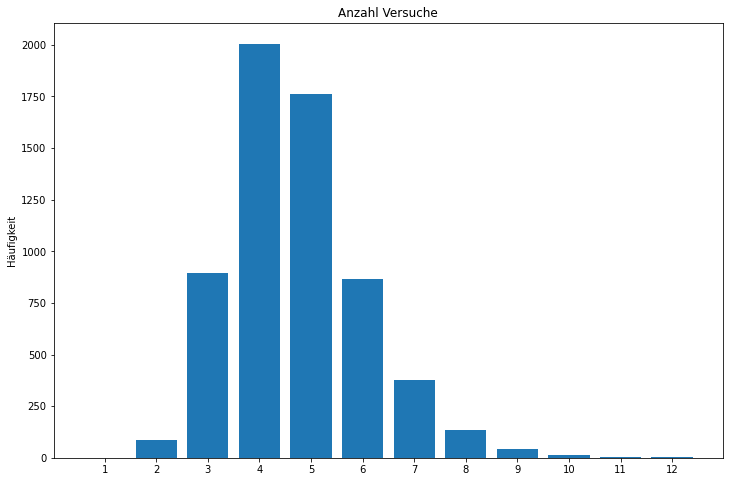

In [11]:
import matplotlib.pyplot as plt

data = [[x,tries_all_words.count(x)] for x in set(tries_all_words)]

fig, axs = plt.subplots(1)
fig.set_size_inches(12, 8)

x = [item[0] for item in data]
y = [item[1] for item in data]

p = axs.bar(x, y)
axs.set_xticks(x, labels=x)
axs.set_ylabel("Häufigkeit")
axs.set_title("Anzahl Versuche")

plt.savefig("AnzahlVersucheAdvancedNetwork.png", transparent=True)

In [12]:
with open("tries_advanced.json", "w") as f:
    json.dump(tries_all_words, f)